# Validating a Reconstruction

This notebook compares our paleoclimate reconstruction to both:
- The original LMRv2.1 (offline) reconstruction
- Multiple instrumental datasets (HadCRUT5, GISTEMP, Berkeley Earth)

We assess the quality of the reconstruction using:
- Global mean surface temperature (GMST) comparisons (median and spread)
- Climate field skill metrics (correlation, coefficient of efficiency)
- Ensemble similarity via the plume distance framework of [Emile-Geay et al. (2025)](https://journals.ametsoc.org/view/journals/clim/38/5/JCLI-D-24-0101.1.xml)

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
print(cfr.__version__)
import pens
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

octave not found, please see README
2025.5.7


### Load Recon Job

Load our reconstruction. We only need to see ```'tas_gm'``` which is the global mean surface temperature (ensemble time series) and ```'tas'``` which is the surface temperature climate field. 

> Note: Here we are validating the reconstruction using the proxy database derived from _Database Assembly using cfr's built in PAGES2k database_ filtered by archive and resolution. Results will vary slightly by variant of Step 2. 

In [2]:
res = cfr.ReconRes('./recons/lmr_reproduce_lipd/')
res.load(['tas', 'tas_gm'])

### Load GMST from our Recon Job 
Here just loading the ```'tas_gm'``` component of our reconstruction

In [3]:
res_ts = res.recons['tas_gm']

### Load LMR offline (original LMRv2.1)
We can do this using Pangeo-Forge, but this one is done by downloading the data directly from the [LMR Data Page](https://www.atmos.uw.edu/~hakim/lmr/LMRv2/index.html). We can then load the GMT  and take the mean across ensembles. 

In [4]:
lmr_off = xr.open_dataset('./prev_data/gmt_MCruns_ensemble_full_LMRv2.1.nc')
lmr_off

<xarray.Dataset> Size: 16MB
Dimensions:  (time: 2001, MCrun: 20, members: 100)
Coordinates:
  * time     (time) object 16kB 0000-01-01 00:00:00 ... 2000-01-01 00:00:00
Dimensions without coordinates: MCrun, members
Data variables:
    gmt      (time, MCrun, members) float32 16MB ...
Attributes:
    description:  Last Millennium Reanalysis climate field reconstruction for...
    experiment:   productionFinal2_gisgpcc_ccms4_LMRdbv1.1.0_tas
    comment:      File contains full ensemble values for each Monte-Carlo rec...

In [5]:
ens_values = lmr_off.gmt.stack(ensemble=['MCrun', 'members']).values  # Shape: (time, MCrun*members)
time_values = lmr_off.time.values
years = np.array([t.year for t in time_values])

(<Figure size 1200x400 with 1 Axes>,
 <Axes: xlabel='Year (CE)', ylabel='Temperature Anomaly (°C)'>)

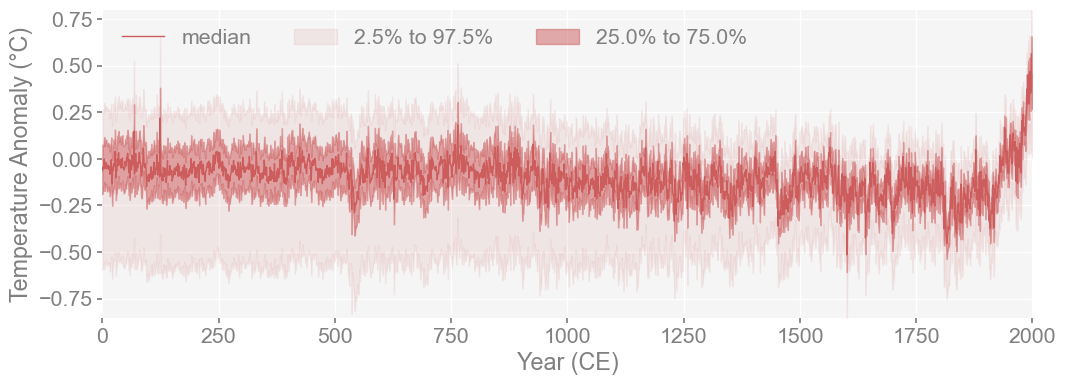

In [6]:
lmr_ens = cfr.EnsTS(time=years, value=ens_values, value_name='Temperature Anomaly (°C)')
lmr_ens.plot_qs()

### Plot both versions of LMR to see comparison

We want to see whether the general shape of the two reconstructions match since we are of course, trying to reproduce it as closely as possible. Mainly, we want to see if the varability is similar between reconstructions and see if they both accurately identified the same climate extremes.

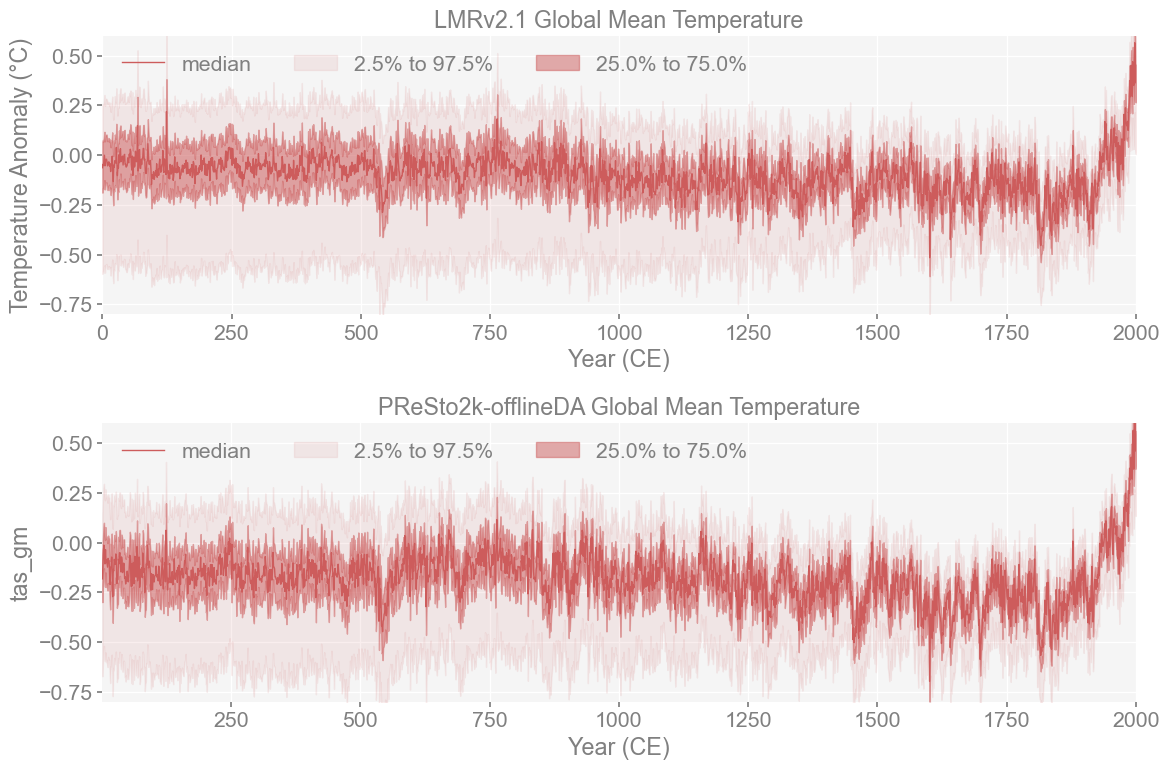

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

res_ts.plot_qs(ax=ax2, ylim=[-0.8, 0.6])
ax2.set_title('PReSto2k-offlineDA Global Mean Temperature')

lmr_ens.plot_qs(ax=ax1, ylim=[-0.8, 0.6]) 
ax1.set_title('LMRv2.1 Global Mean Temperature')

plt.tight_layout()
plt.show()

The ensemble distributions, as plotted here, look very similar, which is encouraging. Let us quantify that using the plume distance framework.

## Validate Using PENS


To quantitatively compare the original LMRv2.1 ensemble to the version reproduced using `cfr`, we apply the plume distance framework introduced by [Emile-Geay et al. (2025)](https://journals.ametsoc.org/view/journals/clim/38/5/JCLI-D-24-0101.1.xml) using the `pens` package.

This framework compares collections of climate trajectories (plumes) by evaluating:
- **Intra-ensemble distances**, which describe the spread of trajectories within an ensemble.
- **Inter-ensemble distances**, which measure differences between two ensembles.
- The **plume distance**, a summary metric (°C) that captures the degree of similarity (or dissimilarity) between two plumes while accounting for internal variability.

We compute these distances using the GMST ensembles from the original LMRv2.1 and our `cfr` reproduction. Both are converted into `pens.EnsembleTS` objects for ease of comparison. 

> The closer the plume distance is to zero, the more statistically similar the ensembles are.

The code computes and visualizes the intra and inter-ensemble distances (within LMRv2.1 and the reproduction) and highlights the plume distance on the plot. 

In [8]:
import pens
import seaborn as sns

plt.style.use('default')
pens.set_style()

In [9]:
# Convert cfr EnsTS to pens EnsTS
glob_pens = pens.EnsembleTS(time=lmr_ens.time, value=lmr_ens.value)
glob_pens.label = 'Original LMR'
glob_pens.time_unit = 'years'
glob_pens.value_name = 'GMST'
glob_pens.value_unit = '\N{DEGREE SIGN}C'

res_pens = pens.EnsembleTS(time=res_ts.time, value=res_ts.value)
res_pens.label = 'PReSto2k-offlineDA'
res_pens.time_unit = 'years'
res_pens.value_name = 'GMST'
res_pens.value_unit = '\N{DEGREE SIGN}C'

In [10]:
# Align time dimension for both EnsTS

glob_time = lmr_ens.time
res_time = res_ts.time.values

common_start = max(glob_time.min(), res_time.min())
common_end = min(glob_time.max(), res_time.max())

# Create time range array
timespan = np.array([common_start, common_end])

# Slice to common period
glob_pens_aligned = glob_pens.slice(timespan)
res_pens_aligned = res_pens.slice(timespan)

In [11]:
orig_intra = glob_pens_aligned.distance()
repro_intra = res_pens_aligned.distance()

# Calculate inter-ensemble distance 
inter_dist = glob_pens_aligned.distance(res_pens_aligned.value)
    
# Calculate plume distance 
plume_dist = glob_pens_aligned.plume_distance(res_pens_aligned.value, max_dist=1.0)

Computing intra-ensemble distance among possible pairs: 100%|██████████| 1999000/1999000 [00:41<00:00, 47745.70it/s]
Computing intra-ensemble distance among possible pairs: 100%|██████████| 1804050/1804050 [00:32<00:00, 54887.59it/s]
Computing inter-ensemble distance: 100%|██████████| 2000/2000 [01:14<00:00, 27.01it/s]


In [12]:
print("\nDistances between ensembles:")
print(f"Original intra-ensemble distance : {orig_intra},\ len={len(orig_intra)}", )
print(f"Reproduced intra-ensemble distance: {repro_intra},\ len={len(repro_intra)}")
print(f"Inter-ensemble distance: {inter_dist}")
print(f"Plume distance: {plume_dist}")


Distances between ensembles:
Original intra-ensemble distance : [0.40367679 0.21343417 0.04743079 ... 0.26221506 0.05118074 0.29547632],\ len=1999000
Reproduced intra-ensemble distance: [0.91594323 0.13586752 0.2780244  ... 0.07902375 0.1659869  0.08696315],\ len=1804050
Inter-ensemble distance: [0.26008597 0.65616499 0.13131738 ... 0.35012316 0.27118268 0.18478717]
Plume distance: 0.1596000477482024


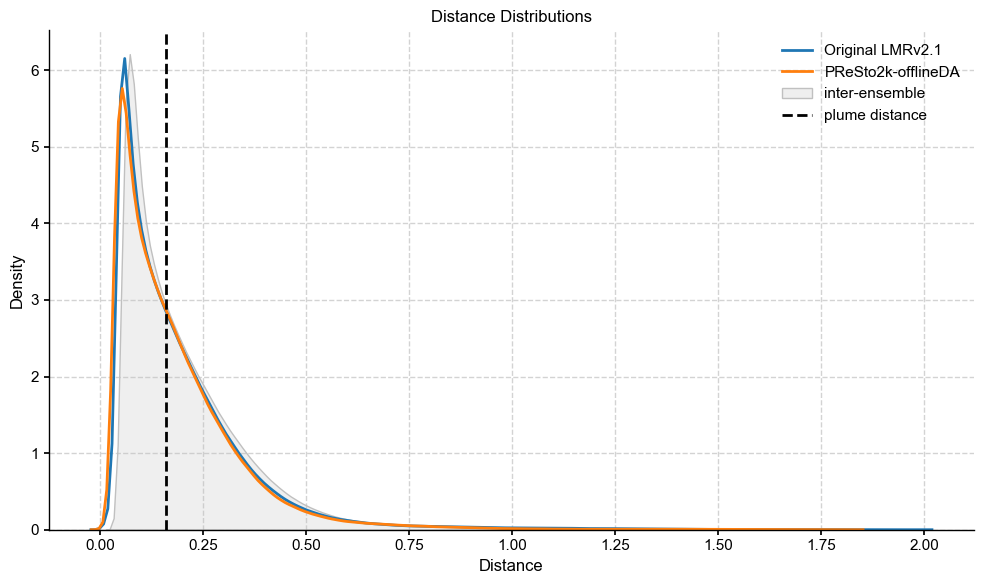

In [13]:
# Create figure and plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot KDE for individual ensembles with explicit labels
sns.kdeplot(data=orig_intra, fill=False, ax=ax, common_norm=False, label='Original LMRv2.1')
sns.kdeplot(data=repro_intra, fill=False, ax=ax, common_norm=False, label='PReSto2k-offlineDA')

# Add inter-ensemble distribution
sns.kdeplot(data=inter_dist, fill=True, ax=ax, common_norm=False, color='silver', 
            label='inter-ensemble')

# Add plume distance line
ax.axvline(x=plume_dist, color="black", linestyle="--", label='plume distance')

# Add labels
ax.set_xlabel('Distance')
ax.set_ylabel('Density')
ax.set_title('Distance Distributions')
ax.legend()

plt.tight_layout()
plt.show()

The distance between my reproduced LMRv2.1 and the original falls within the spread of intra-ensemble variability, and tracks almost exactly with the original distribution, which shows that the reconstructions are very similar and within expected error of each other.

## Validating GMST Against Instrumental Datasets

Firstly we will validate our reconstruction's GMST against the original LMRv2.1 (offline) and some instrumental datasets (HadCRUT4, BEST, GISTEMP). Since data was not available for all instrumental datasets, we are using whichever ones we can find an exact match for, all of which came from the [initial data folder](http://www.atmos.uw.edu/~wperkins/nobackup/lmr_data/LMR_data.tar.gz). \
\
_cfr_'s ```EnsTS.compare()``` will take the ensemble time series and the plot the median and the spread of our original dataset and plot it against the target, or validation, dataset. 

> Note: Validation is restricted to 1880–2000, the common period across reconstructions and observational datasets.


### Validate against GISS Surface Temperature Analysis (GISTEMP)

The first dataset we will use to validate is [GISTEMP](https://data.giss.nasa.gov/gistemp/news/2010summer/). This exact set was used by Tardif et al. (2019) to validate their reconstruction. Additionally we used it for calibration, so we expect the match against our reconstruction to be fairly high. 

First we load load dataset using xarray, then convert to a _cfr_ ```EnsTS``` (Ensemble Time Series) object

In [14]:
gis = xr.load_dataset('./analyses/GISTEMP/gistemp1200_ERSSTv4.nc')
gis.head()

<xarray.Dataset> Size: 660B
Dimensions:      (lat: 5, lon: 5, time: 5, nv: 2)
Coordinates:
  * lat          (lat) float32 20B -89.0 -87.0 -85.0 -83.0 -81.0
  * lon          (lon) float32 20B -179.0 -177.0 -175.0 -173.0 -171.0
  * time         (time) datetime64[ns] 40B 1880-01-15 1880-02-15 ... 1880-05-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 80B 1880-01-01 ... 1880-06-01
    tempanomaly  (time, lat, lon) float32 500B nan nan nan nan ... nan nan nan
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2017-05-12 10:40:20 by SBBX_to_nc 2.0 - ILAND=1200,...

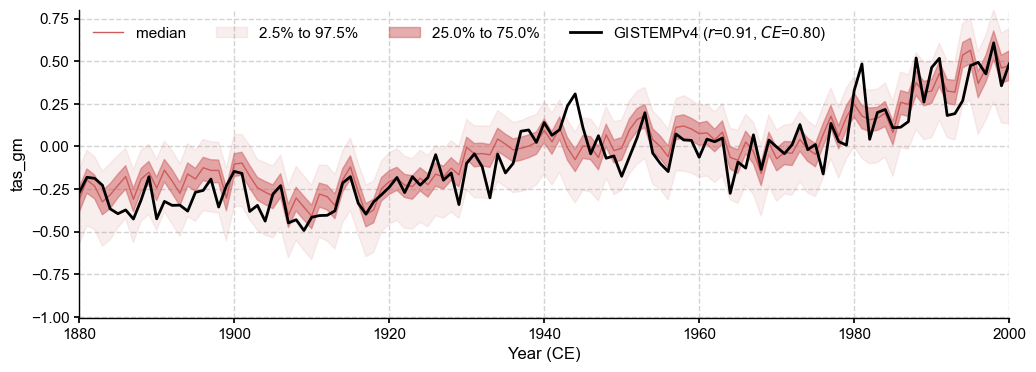

In [15]:
gm = gis.tempanomaly.mean(dim=['lat', 'lon'])
gis_annual = gm.groupby('time.year').mean()

# Make sure values are properly shaped ([,:1])
gis_values = gis_annual.values
if gis_values.ndim == 1:
    gis_values = gis_values[:, np.newaxis] 

# annualize GISTEMP
gis_ts_annual = cfr.EnsTS(
    time=gis_annual.year.values,
    value=gis_values,
    value_name='Temperature Anomaly'
)

# Compare LMR with annual data
gis_ts_compared = res_ts.compare(
    gis_ts_annual, 
    ref_name='GISTEMPv4', 
    timespan=(1880, 2000)
)

fig, ax = gis_ts_compared.plot_qs(figsize=[12, 4], xlim=[1880,2000])

This comparison evaluates my LMRv2.1 reproduction against GISTEMP, using GISTEMP as the reference. Since the Coefficient of Efficiency (CE) is not symmetric, this direction matters. The result reflects how well the reconstruction explains variance compared to the instrumental record. 

The reconstruction shows a strong match with GISTEMPv4, with r = 0.91 and CE = 0.80. Since GISTEMPv4 was the actual temperature calibration set used in LMRv2.1, this agreement between the two is expected. This shows that the reconstruction captures both the trend and variability present in the instrumental temperature recordand it stays well within the ensemble spread for most of the period, which suggests that the emulation is sucessful. 

### Validate against HadCRUT4

Same process as before, but this time we use [HadCRUT5](https://www.metoffice.gov.uk/hadobs/hadcrut5/). This time we load the dataset from the cloud, then convert the dataframe to a _cfr_ ```EnsTS``` (Ensemble Time Series) object
> Note: Tardif et al. (2019) used HadCRUT4 to validate, but since we are running this experiment six years later, it is best to use more up-to-date data. 

In [16]:
url = 'https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/diagnostics/HadCRUT.5.0.2.0.analysis.summary_series.global.annual.csv'
df = pd.read_csv(url)
df.head()

,Time,Anomaly (deg C),Lower confidence limit (2.5%),Upper confidence limit (97.5%)
0,1850,-0.417711,-0.589256,-0.246166
1,1851,-0.233350,-0.411868,-0.054832
2,1852,-0.229399,-0.409382,-0.049416
3,1853,-0.270354,-0.430009,-0.110700
4,1854,-0.291521,-0.432712,-0.150330


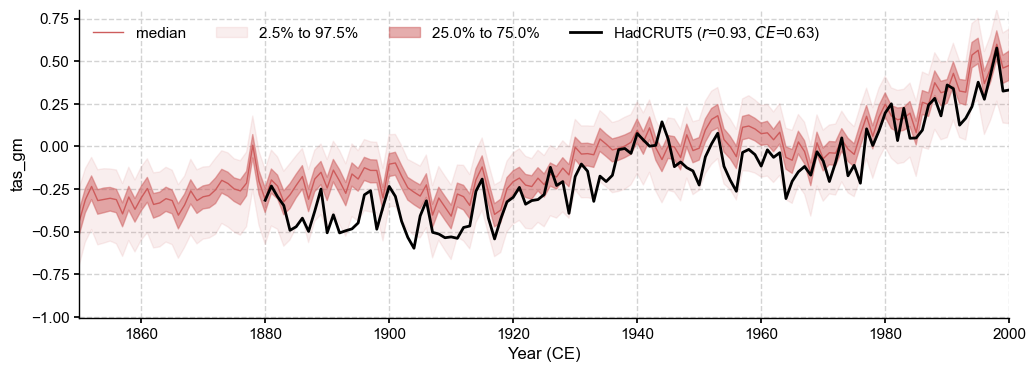

In [17]:
had_ts_annual = cfr.EnsTS().from_df(df=df,time_column='Time', value_columns='Anomaly (deg C)')
had_ts_compared = res_ts.compare(
    had_ts_annual, 
    ref_name='HadCRUT5', 
    timespan=(1880, 2000)
)

fig, ax = had_ts_compared.plot_qs(figsize=[12, 4], xlim=[1850,2000])


The reconstruction shows a strong match with HadCRUT4, with a correlation of r=0.91 and CE = 0.64. This is a strong match, especially considering that HadCRUT4 was not used in the calibration (GISTEMPv4 was used for temperature). The reconstruction still aligns well with an independent dataset and shows that the reproduction closely emulates LMRv2.1 as well as the instrumental record.

### Validate against Berkeley Earth Surface Temperature (BEST)

Same process as before, but for [BEST](https://berkeleyearth.org/data/). First we use `load_dataset` using xarray, then convert to a _cfr_ `EnsTS` (Ensemble Time Series) object

In [18]:
best = xr.load_dataset('./analyses/BerkeleyEarth/Land_and_Ocean_LatLong1.nc')
best

<xarray.Dataset> Size: 517MB
Dimensions:      (longitude: 360, latitude: 180, time: 1980, month_number: 12)
Coordinates:
  * longitude    (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude     (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time         (time) float64 16kB 1.85e+03 1.85e+03 ... 2.015e+03 2.015e+03
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 518kB 1.0 1.0 1.0 ... 0.0 0.0 0.0
    temperature  (time, latitude, longitude) float32 513MB nan nan ... 0.4641
    climatology  (month_number, latitude, longitude) float32 3MB -28.21 ... -...
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               17-Feb-2015 11:17:51
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   16-Jan-2015 09:30:27
    ocean_source_history:  08-Jan-2015 06:07:03
    comment:               This file contains Berkeley Earth surface temperat...

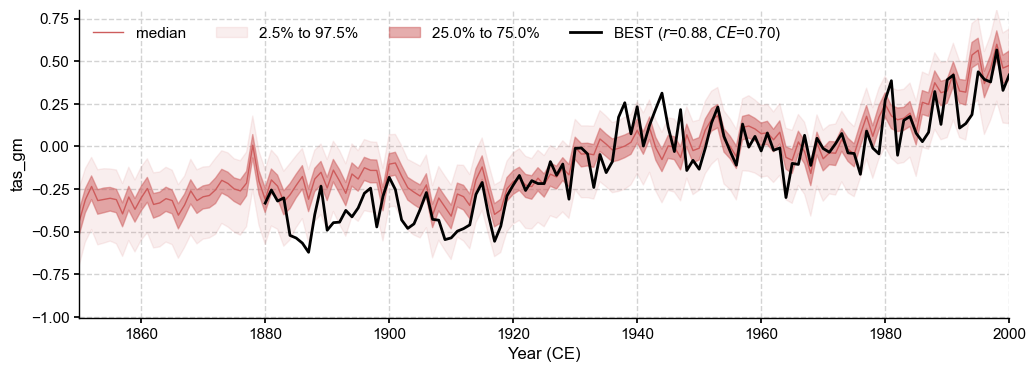

In [19]:

gm = best.temperature.mean(dim=['latitude', 'longitude'])

# Convert time coordinate to datetime index (specific to BEST)
time_index = pd.date_range(start='1850-01-01', periods=len(best.time), freq='M')
gm = gm.assign_coords(time=time_index)

best_annual = gm.groupby('time.year').mean()

# Reshape values if needed
best_values = best_annual.values
if best_values.ndim == 1:
    best_values = best_values[:, np.newaxis]

# annualize
best_ts_annual = cfr.EnsTS(
    time=best_annual.year.values,
    value=best_values,
    value_name='Temperature Anomaly'
)

# Compare LMR with annual data
best_ts_compared = res_ts.compare(
    best_ts_annual,
    ref_name='BEST',
    timespan=(1880, 2000)
)

fig, ax = best_ts_compared.plot_qs(figsize=[12, 4], xlim=[1850, 2000])

Similarly to HADCRUT5, the reconstruction shows a strong match with BEST, with a correlation of r=0.88 and CE = 0.69. This is still a strong match, since BEST was also not used in the calibration. The reconstruction still aligns well with an independent dataset and shows that the reproduction closely emulates LMRv2.1 as well as the instrumental record.

### Plot Consensus

In addition to the individual validation analyses, we can now plot them all together along with a 'consensus' time series, which is the mean of all the instrumental datasets. 

> We create a consensus validation target by averaging HadCRUT5, GISTEMP, and BEST time series.


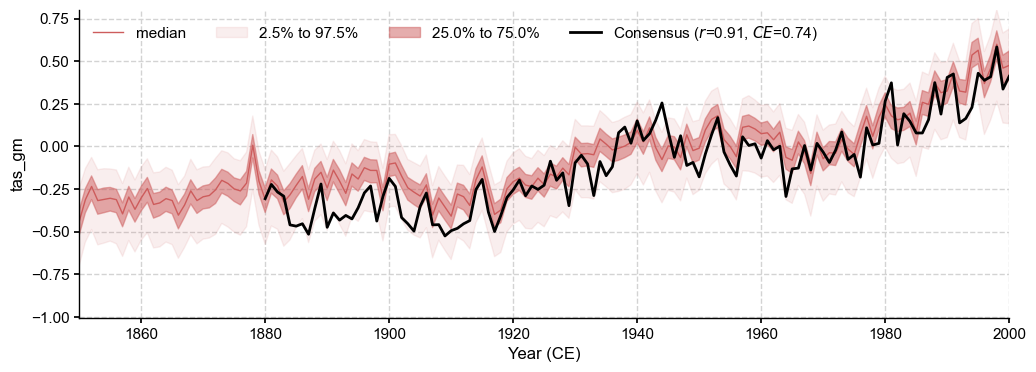

In [20]:
# combine all datasets to calculate mean
all_refs = np.array([
   had_ts_compared.ref_value[:121],
   gis_ts_compared.ref_value[:121],
   best_ts_compared.ref_value[:121]
])
mean_ref = np.mean(all_refs, axis=0)

mean_ts_annual = cfr.EnsTS(
    time=best_annual.year.values[30:-14], #manually slice dates
    value=mean_ref,
    value_name='Temperature Anomaly'
)

mean_ts_compared = res_ts.compare(
    mean_ts_annual,
    ref_name='Consensus',
    timespan=(1880, 2000)
)

fig, ax = mean_ts_compared.plot_qs(figsize=[12, 4], xlim=[1850, 2000])

Text(0.5, 1.0, 'PReSto2k-offlineDA vs Observational Data 1880-2000')

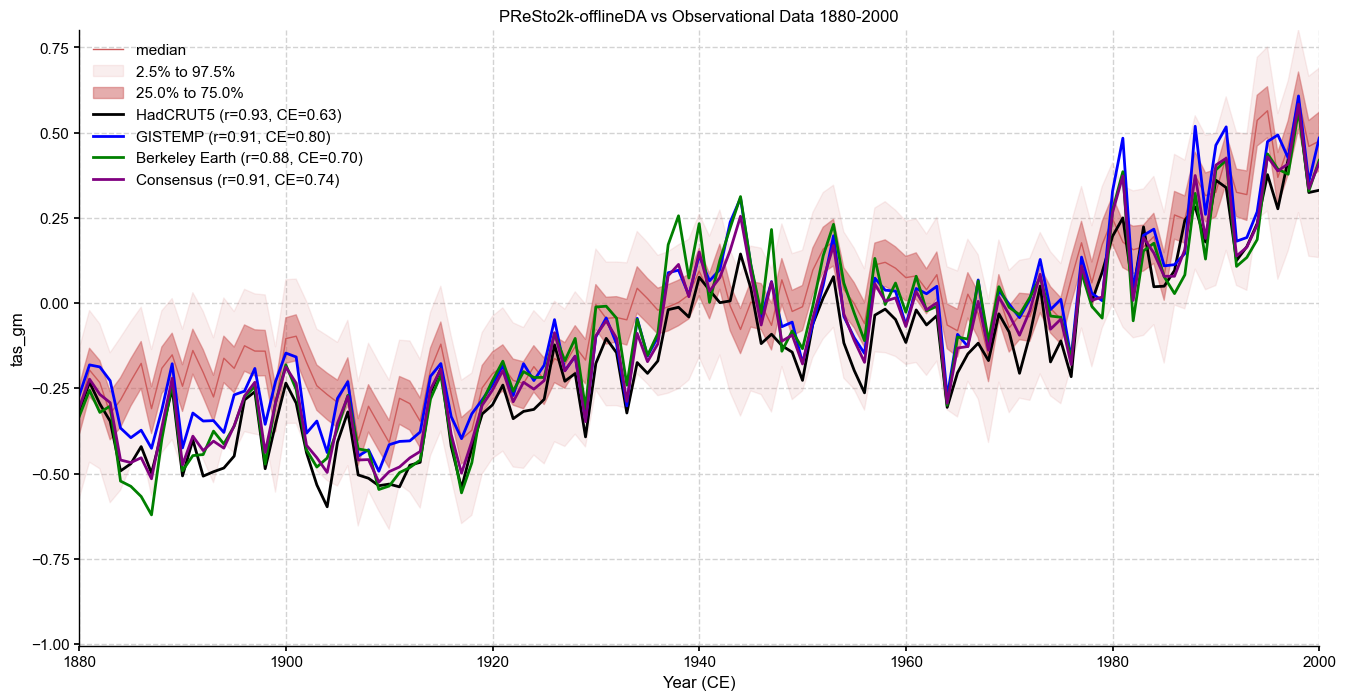

In [21]:
# Create base plot without validation plot
fig, ax = had_ts_compared.plot_qs(
   figsize=[16, 8], 
   xlim=(1880, 2000),
   color='indianred',
   plot_valid=False 
)

for compared, color, label in [
   (had_ts_compared, 'black', 'HadCRUT5'),
   (gis_ts_compared, 'blue', 'GISTEMP'),
   (best_ts_compared, 'green', 'Berkeley Earth'),
   (mean_ts_compared, 'purple', 'Consensus')
   
]:
   stats = compared.valid_stats
   label = f'{label} (r={stats["corr"]:.2f}, CE={stats["CE"]:.2f})'
   ax.plot(compared.ref_time, compared.ref_value[:121], color=color, label=label)


plt.legend()
plt.title('PReSto2k-offlineDA vs Observational Data 1880-2000')

The reconstruction aligns closely with the instrumental consensus series, with r=0.91 and CE=0.74. This consensus represents an average across multiple observational datasets, so strong agreement here reinforces that the reconstruction captures the core features of the instrumental record. The fact that all targets (HadCRUT4, GISTEMPv4, BEST, and the consensus) fall within the ensemble spread shows the robustness of the reproduced reconstruction.

## Validate Climate Field

### Load field reconstruction 

Load in the original LMR ```air``` (2m air temperature) climate field as a _cfr_ `ClimateField` object and modify the format so that we can more easily compare it with our validation datasets using _cfr_. In this step, we will plot both the correlation (corr) and the coefficient of efficiency (CE) of 2m air temperature against the Berkeley Earth Surface Temperature (BEST) climate field, since that was what Tardif et al. (2019) used to validate their field reconstructions. 

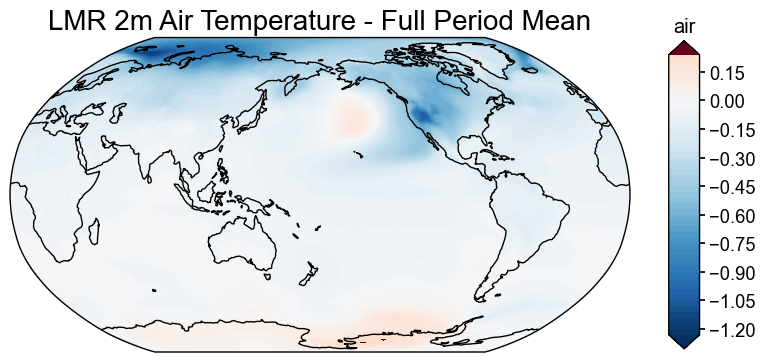

In [ ]:
# Load the data as a ClimateField object
lmr_tas = cfr.ClimateField().load_nc(
    path='./prev_data/air_MCruns_ensemble_mean_LMRv2.1.nc',
    vn='air', 
    time_name='time',  
    lat_name='lat', 
    lon_name='lon'
)

# Take the mean across the MCrun dimension
if 'MCrun' in lmr_tas.da.dims:
    lmr_tas.da = lmr_tas.da.mean(dim='MCrun')

# Calculate the time mean across the entire dataset
lmr_tas_mean = lmr_tas.da.mean(dim='time')

# Create a new ClimateField with this time-mean data
mean_field = cfr.ClimateField()
mean_field.da = lmr_tas_mean
# Add a name to the DataArray 
mean_field.da.name = 'air'


vmax = np.nanmax(np.abs(mean_field.da.values))
clim = (-vmax, vmax)

fig,ax = mean_field.plot(
    title="LMR 2m Air Temperature - Full Period Mean",
    plot_cbar=True,
    cmap='RdBu_r',
    clim=clim   # enforce centered colormap
)



### Loading reproduced

Opening one reconstruction file to check its formatting. Then plot the results of the full ```'tas'``` reconstruction to make sure it works and looks the way it should.

In [23]:
xr.open_dataset('./recons/lmr_reproduce_pda_ptype_res/job_r01_recon.nc')

<xarray.Dataset> Size: 96MB
Dimensions:  (time: 2000, ens: 100, lat: 42, lon: 63)
Coordinates:
  * time     (time) int64 16kB 1 2 3 4 5 6 7 ... 1995 1996 1997 1998 1999 2000
  * ens      (ens) int64 800B 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
  * lat      (lat) float64 336B -90.0 -85.61 -81.22 -76.83 ... 81.22 85.61 90.0
  * lon      (lon) float64 504B 0.0 5.806 11.61 17.42 ... 348.4 354.2 360.0
Data variables:
    tas_gm   (time, ens) float64 2MB ...
    tas_nhm  (time, ens) float64 2MB ...
    tas_shm  (time, ens) float64 2MB ...
    nino3.4  (time, ens) float64 2MB ...
    tas      (time, lat, lon) float64 42MB ...
    pr_gm    (time, ens) float64 2MB ...
    pr_nhm   (time, ens) float64 2MB ...
    pr_shm   (time, ens) float64 2MB ...
    pr       (time, lat, lon) float64 42MB ...
Attributes:
    pids_assim:  ['NAm_153', 'Asi_178', 'Asi_174', 'Asi_198', 'Arc_071', 'NAm...
    pids_eval:   ['NAm_165', 'NAm_145', 'NAm_193', 'Asi_098', 'NAm_086', 'Asi...

(<Figure size 1000x800 with 2 Axes>, <GeoAxes: title={'center': 'tas, 1'}>)

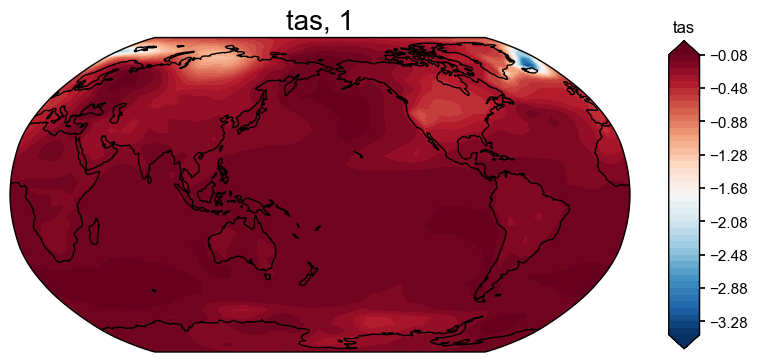

In [24]:
res_tas = res.recons['tas']
res_tas.plot()

### Validating our reconstruction using BEST 
LMR did their climate field validation against BEST, so we will do the same to get our correlation and CE metrics. The formatting is the same process as above, but wrapping the longitude and alterating time array to be in datetime format.

In [25]:
ds = xr.open_dataset('./analyses/BerkeleyEarth/Land_and_Ocean_LatLong1.nc')

# Convert decimal years to datetime
years = ds.time.values
dates = pd.to_datetime([f"{int(year)}-{int((year % 1) * 12 + 1):02d}-15" for year in years])

# Create a new DataArray with proper coordinates
da = xr.DataArray(
    ds.temperature.values,
    coords={
        'time': dates,
        'lat': ds.latitude.values,
        'lon': ds.longitude.values
    },
    dims=['time', 'lat', 'lon'],
    name='temperature'
)

# 3. create ClimateField object
target_be = cfr.ClimateField(da).get_anom(ref_period=[1951, 1980])
target_be = target_be.annualize(months=[12, 1, 2])
target_be.da

<xarray.DataArray 'temperature' (time: 166, lat: 180, lon: 360)> Size: 43MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
...
        [ 4.596744  ,  4.5938563 ,  4.5843997 , ...,  4.6102543 ,
          4.6037235 ,  4.597175  ],
        [ 4.673825  ,  4.6759253 ,  4.678038  , ...,  4.6678166 ,
          4.669744  ,  4.6717496 ],
        [ 4.7714734 ,  4.771113  ,  4.7707725 , ...,  4.7726264 ,
          4.7722254 ,  4.7718444 ]],

       [[ 0.3548702 ,  0.35387096,  0.35291004, ...,  0.358096  ,
          0.356983  ,  0.35590762],
        [ 0.10089615,  0.09855123,  0.09632224, ...,  0.10862842,
          0.10593477,  0.10335734],
        [-0.16927919, -0.17242013, -0.1753236 , ..., -0.15843871,
         -0.16228755, -0.16590136],
        ...,
        [-0.1783086 , -0.17734027, -0.18252498, ..., -0.17535889,
         -0.18095711, -0.17951155],
        [ 0.06656009,  0.07851714,  0.09048697, ...,  0.03132993,
          0.04293364,  0.05467859],
        [ 0.17753503,  0.17946205,  0.18142337, ...,  0.17188016,
          0.17373574,  0.17562625]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) int64 1kB 1850 1851 1852 1853 1854 ... 2012 2013 2014 2015
Attributes:
    annualized:  1

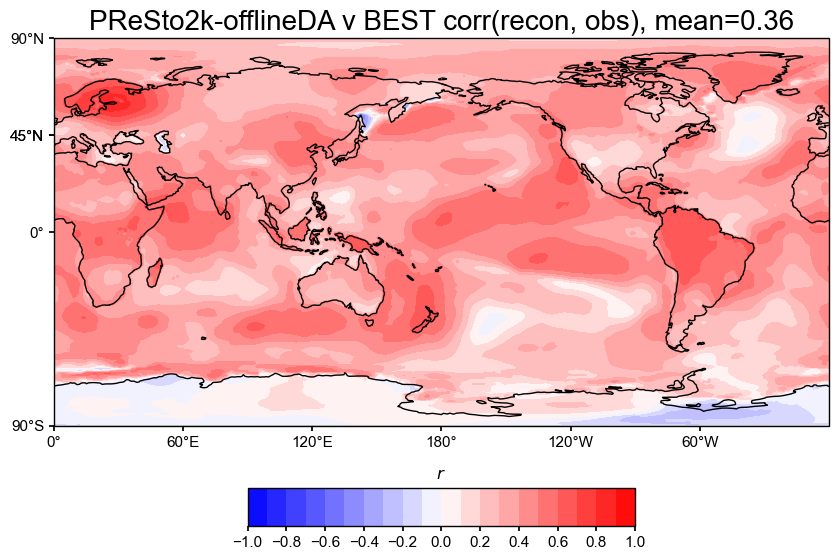

In [26]:
# Convert target data to 0-360 format first
target_wrapped = target_be.wrap_lon(mode='360')

# Then do the comparison (correlation)
valid_fdb = res.recons['tas'].compare(
    target_wrapped,
    stat='corr',
    timespan=(1880, 2000),
)

# Plot with updated settings
valid_fdb.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fdb.plot(
    title=f'PReSto2k-offlineDA v BEST corr(recon, obs), mean={valid_fdb.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-90, 90, 0, 360),
    plot_cbar=True,
    plot_proxydb=False,
    cmap='bwr'
)

cfr.showfig(fig)

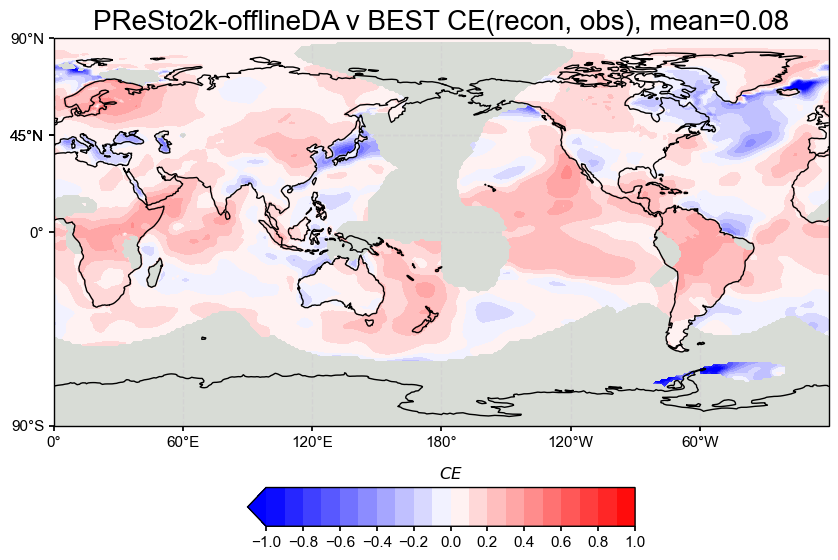

In [27]:
# Then do the comparison (CE)
valid_fdbx = res.recons['tas'].compare(
    target_wrapped,
    stat='CE',
    timespan=(1880, 2000),
)

# Plot with updated settings
valid_fdbx.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fdbx.plot(
    title=f'PReSto2k-offlineDA v BEST CE(recon, obs), mean={valid_fdbx.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-90, 90, 0, 360),
    plot_cbar=True,
    plot_proxydb=False,
    cmap='bwr'
)

cfr.showfig(fig)

### Validating the original LMRv2.1 using BEST
We need to compare both the orignal LMRv2.1 with our reconstruction against the same validation data, in this case, BEST. We will repeat the same steps as above to calculate correlation and CE. 

In [28]:
lmr_tas = cfr.ClimateField().load_nc(
    path='./prev_data/air_MCruns_ensemble_mean_LMRv2.1.nc',
    vn='air', 
    time_name='time',  
    lat_name='lat', 
    lon_name='lon'
)

target_lmr = lmr_tas.get_anom(ref_period=[1951, 1980])
filtered_da = target_lmr.da.sel(time=target_lmr.da.time.dt.year != 0)
target_lmr = cfr.ClimateField(da=filtered_da)
target_lmr = target_lmr.annualize(months=[12, 1, 2])

target_lmr_mean = cfr.ClimateField(da=target_lmr.da.mean(dim='MCrun'))


In [29]:
print(target_lmr.da.dims)

('time', 'MCrun', 'lat', 'lon')


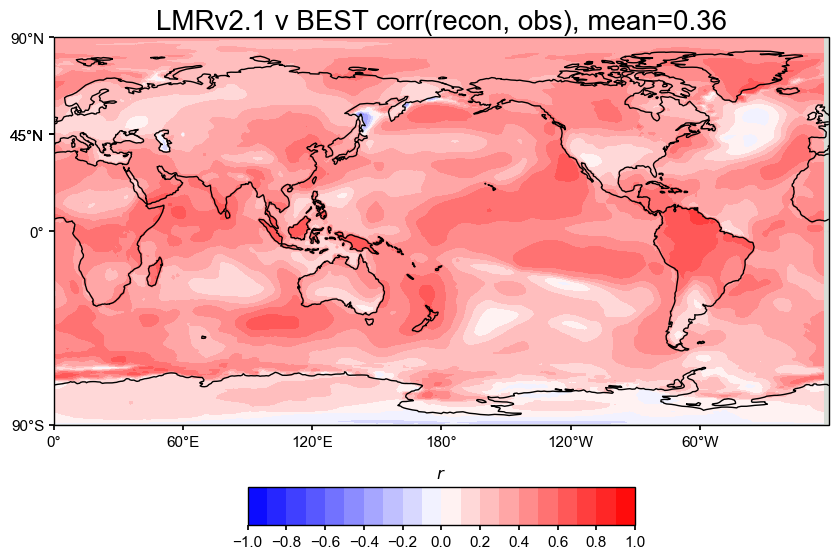

In [30]:
# Then do the comparison
valid_fdb = target_lmr_mean.compare(
    target_wrapped,
    stat='corr',
    timespan=(1880, 2000),
)

# Plot with updated settings
valid_fdb.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fdb.plot(
    title=f'LMRv2.1 v BEST corr(recon, obs), mean={valid_fdb.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-90, 90, 0, 360),
    plot_cbar=True,
    plot_proxydb=False,
    cmap='bwr'
)

cfr.showfig(fig)

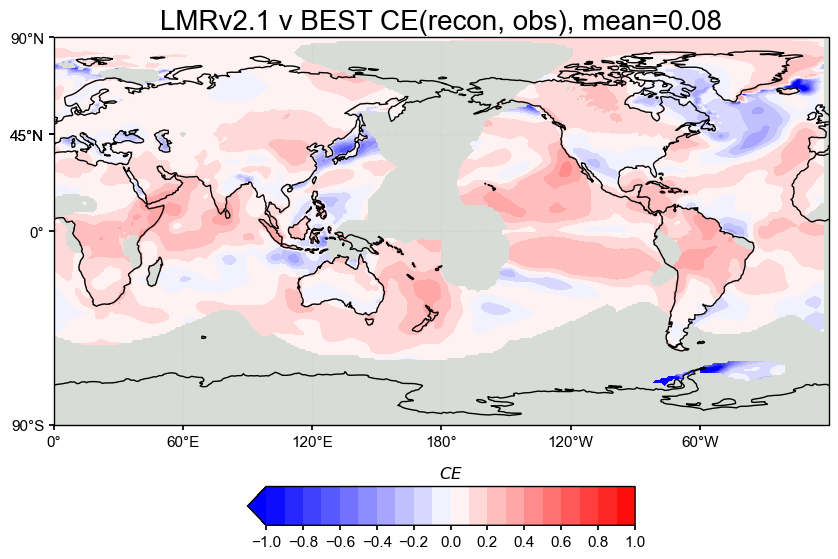

In [31]:
# Then do the comparison
valid_fdbx = target_lmr_mean.compare(
    target_wrapped,
    stat='CE',
    timespan=(1880, 2000),
)

# Plot with updated settings
valid_fdbx.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fdbx.plot(
    title=f'LMRv2.1 v BEST CE(recon, obs), mean={valid_fdbx.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-90, 90, 0, 360),
    plot_cbar=True,
    plot_proxydb=False,
    cmap='bwr'
)

cfr.showfig(fig)

The spatial correlation and CE maps show that our reproduced LMRv2.1 reconstruction performs nearly identically to the original LMRv2.1, with both having a correlation of 0.36 and a global mean CE of 0.08 when compared against BEST.

**Correlation (r)**:
The correlation maps show strong agreement across most of the globe, especially in the tropics, both land and ocean. The patterns look almost exactly the same between the original and reproduced versions, which suggests that the proxy database filtering steps were esential to emulating the reconstruction accurately.

**Coefficient of Efficiency (CE)**:
CE is lower overall, which is as expected from the results of the paper, but still positive across most regions. Areas with negative CE are consistent within in both versions. The mean CE of 0.08 is fairly low but is a drastic improvement from negative values from past attempts at emulating LMRv2.1. 

Overall, these plots suggest that the reproduced reconstruction preserves the spatial performance of the original and matches the observational target about as well as expected.

### Validating our Reconstruction against original LMRv2.1

We validated both against instrumental data, but it is also important to see how our reproduction compares to the original, using the original LMRv2.1 as the target.

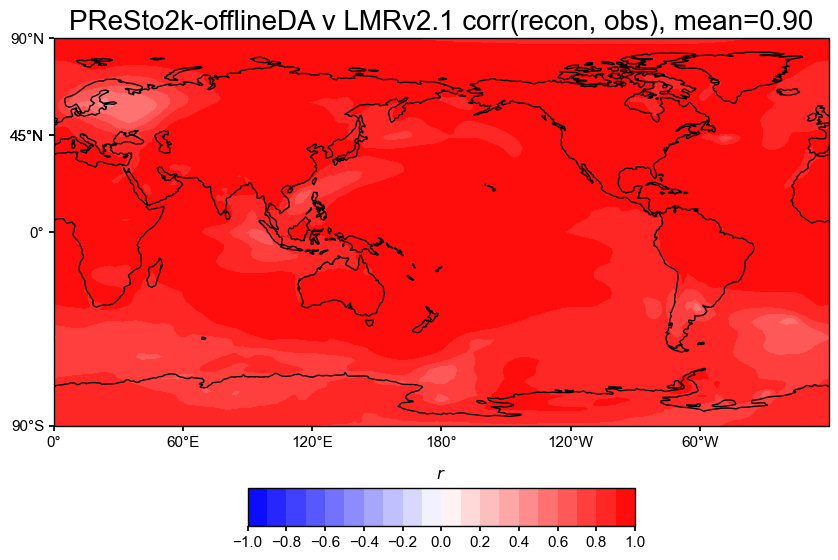

In [32]:
# Then do the comparison
valid_fdb = res.recons['tas'].compare(
    target_lmr_mean,
    stat='corr',
    timespan=(1880, 2000),
)

# Plot with updated settings
valid_fdb.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fdb.plot(
    title=f'PReSto2k-offlineDA v LMRv2.1 corr(recon, obs), mean={valid_fdb.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-90, 90, 0, 360),
    plot_cbar=True,
    plot_proxydb=False,
    cmap='bwr'
)

cfr.showfig(fig)

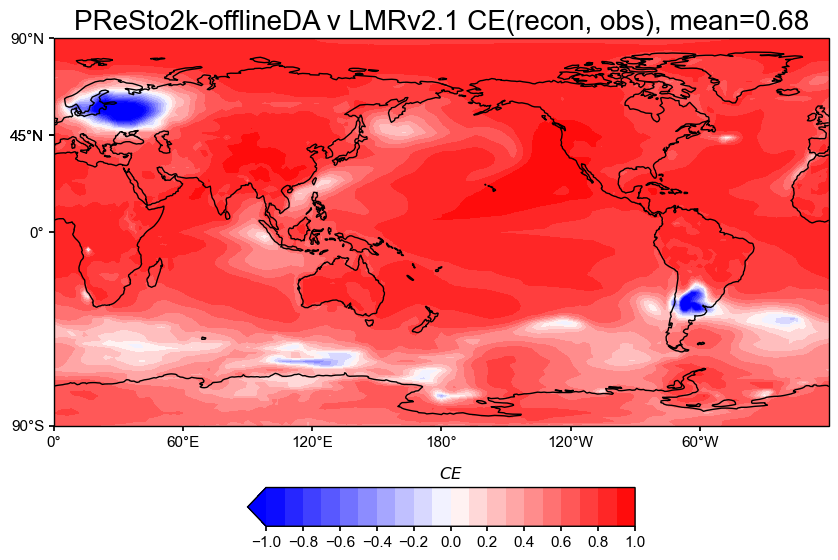

In [33]:
# Then do the comparison
valid_fdb = res.recons['tas'].compare(
    target_lmr_mean,
    stat='CE',
    timespan=(1880, 2000),
)

# Plot with updated settings
valid_fdb.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fdb.plot(
    title=f'PReSto2k-offlineDA v LMRv2.1 CE(recon, obs), mean={valid_fdb.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-90, 90, 0, 360),
    plot_cbar=True,
    plot_proxydb=False,
    cmap='bwr'
)

cfr.showfig(fig)

The spatial correlation and CE maps show that the reproduced reconstruction matches the original LMRv2.1 almost perfectly.

**Correlation (r)**:
The correlation map has a global mean of 0.94, which is extremely high. Nearly the entire globe is bright red, meaning the two fields match both spatially and in time. 

**Coefficient of Efficiency (CE)**:
High CE values across most regions show that the reconstruction captures both variability and amplitude much better than a flat mean would. There are very few regions where the reconstruction underperforms the mean baseline, which is another drastic improvement from previous negative CE values. 

Again, this confirms that the reproduction is a good match to the original LMRv2.1, both spatially and averaged.

## Summary

We reproduced the LMRv2.1 global temperature reconstruction using the PAGES2k proxy database from the _cfr_ package.

To get a close match, we filtered the proxies by both archive type and resolution (dt ≤ 1), which brought the number of records closer with those used in the original LMRv2.1.

After validating, the reproduced reconstruction matches the original very closely:

- Global mean temperature time series align well with instrumental data sets and with the orignal LMRv2.1
- Spatial correlation and CE maps show nearly identical patterns against instrumental data and the orignal LMRv2.1
- There is strong agreement with independent observational targets (HadCRUT4, GISTEMPv4, BEST)


In future work: 

- More thoroughly explore how different filtering choices in the proxy database affect skill.
- Include additional calibration targets such as precipitation
- Include marine sediments into the proxy network 


In [34]:
## EXTRA EXTRA DELETE
res2 = cfr.ReconRes('./recons/lmr_reproduce_pda_ptype_res/')
res2.load(['tas', 'tas_gm'])


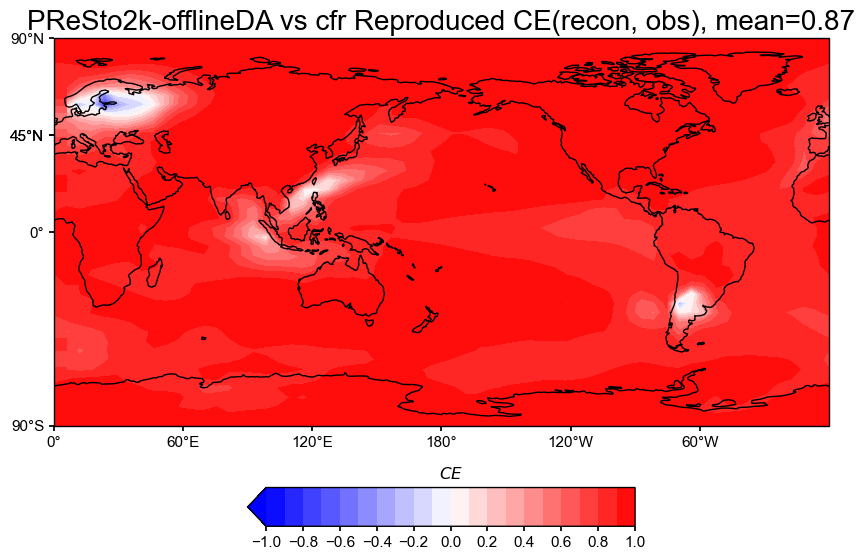

In [35]:


# Then do the comparison (CE)
valid_fdbx = res.recons['tas'].compare(
    res2.recons['tas'],
    stat='CE',
    timespan=(1880, 2000),
)

# Plot with updated settings
valid_fdbx.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fdbx.plot(
    title=f'PReSto2k-offlineDA vs cfr Reproduced CE(recon, obs), mean={valid_fdbx.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-90, 90, 0, 360),
    plot_cbar=True,
    plot_proxydb=False,
    cmap='bwr'
)

cfr.showfig(fig)

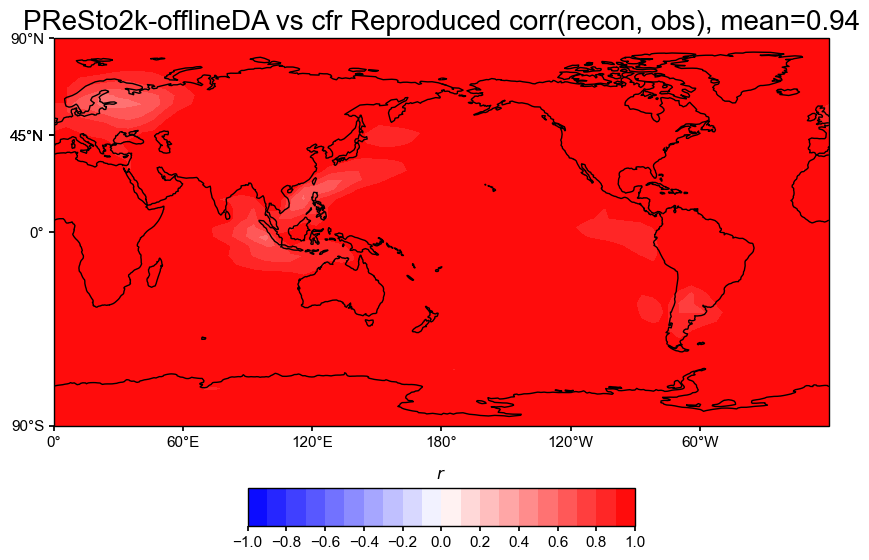

In [36]:

# Then do the comparison (CE)
valid_fdbx = res.recons['tas'].compare(
    res2.recons['tas'],
    stat='corr',
    timespan=(1880, 2000),
)

# Plot with updated settings
valid_fdbx.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fdbx.plot(
    title=f'PReSto2k-offlineDA vs cfr Reproduced corr(recon, obs), mean={valid_fdbx.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-90, 90, 0, 360),
    plot_cbar=True,
    plot_proxydb=False,
    cmap='bwr'
)

cfr.showfig(fig)